In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# color for print function
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [2]:
iris = pd.read_csv('iris.csv').sort_values("variety", ascending=True) # read iris data and sort by "variety"
variety = iris.pop('variety')                                         # pop out the "variety"
iris.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
27,5.2,3.5,1.5,0.2
28,5.2,3.4,1.4,0.2
29,4.7,3.2,1.6,0.2
30,4.8,3.1,1.6,0.2


In [3]:
variety_count = variety.value_counts()
variety_dict = variety_count.keys()

print("The species of iris are: {}".format(list(variety_dict)))
print("The numbers of that species are: {}".format(list(variety_count)))

The species of iris are: ['Versicolor', 'Virginica', 'Setosa']
The numbers of that species are: [50, 50, 50]


In [4]:
### K Fold algorithm
def K_Fold(data, label_count, K = 5):
    # get k fold index for data rows
    Kfold_idx = np.array([np.random.choice(count, count, replace=False) for count in label_count])

    # default setting for K Fold
    valid_size = Kfold_idx.shape[1] // K
    Kfold_idx_reshaped = Kfold_idx.reshape(len(label_count), K, valid_size)

    # K Fold loop
    valid_list = []
    train_list = []
    for k in range(K):
        print("Under Fold: {}".format(k + 1))
        print("--------------")
        train = np.empty((0, data.shape[1])) # np.empty will create size of array contains unknown numbers
        for i in range(K):
            print("  iter = {}".format(i))

            if k == i:
                for fold in Kfold_idx_reshaped[:, i, :]:
                    valid = np.array(data.iloc[fold, ])
                    
            else:
                for idx, fold in enumerate(Kfold_idx_reshaped[:, i, :]):
                    tmp_train = np.array(data.iloc[fold, ])
                    train = np.concatenate([train, tmp_train])

        valid_list.append(valid)  # shape (5, 10, 4)
        train_list.append(train)  # shape (5, 120, 4)
        print()
    
    
    return np.array(train_list), np.array(valid_list)

In [5]:
# activation function to adjust the delta weight
def activation_MinusBack(input_array):
    size = input_array.size
    minus_back = 1 / size
    
    output_array = input_array/input_array.sum() - minus_back
    return output_array

def activation_AdjustMean(input_array):
    output_array = input_array - input_array.mean()
    return output_array

In [6]:
## Competitive Learning Process
def CompetitiveLearning(data, label_count, EPOCH=5000, eta=.0001):
    # get default info
    outputSize = len(label_count)
    data_normalized = data/data.sum(axis=0)
    labels = np.repeat(range(outputSize), label_count)

    # shuffle the data no matter shuffled or not
    random_idx = np.random.choice(range(labels.size), size=labels.size, replace=False)
    data_shuffled = data_normalized[random_idx, :]
    labels_shuffled = labels[random_idx]

    # random weights from normal distribution
    random_weights = np.random.normal(0, 1, size=(data_shuffled.shape[1], outputSize))

    # adjust the weights so that the sum of them is equal to 1
    weights  = random_weights / random_weights.sum()
    
    Accuracy = []
    for epoch in range(EPOCH):
        for row in data_shuffled:
            ## compute the winner
            output = np.dot(row, weights)                                       # dot product of data and weights
            winner = np.argmax(output)                                          # indicate the winner

            ## compute the delta weight
            delta_weight = np.zeros(weights.shape)                              # create 2d zeros array for delta weight
            delta_weight_for_winner = eta * (row/row.size - weights[:, winner]) # compute the delta weight for winner
            delta_weight_adj = activation_AdjustMean(delta_weight_for_winner)   # adjust the delta weight so that the sum is 0
            delta_weight[:, winner] = delta_weight_adj                          # put the delta weight into 2d array

            ## update weight
            weights += delta_weight
        
        ## Compute accuracy for each epoch
        output = np.dot(data_shuffled, weights)
        labels_pred = np.argmax(output, axis=1)
        acc = (labels_pred == labels_shuffled).mean()
        if (epoch+1) % 1000 == 0:
            print("Epoch = {}  Accuracy: {}".format(epoch+1, acc))
        Accuracy.append(acc)
        
    return weights, np.array(Accuracy)

In [7]:
## Main function
def main(KFOLD_DATA, LABEL_COUNTS, EPOCH=5000, ETA=.00000001):
    WEIGHTS = []
    ACCURACY = []
    for kfold in range(len(KFOLD_DATA)):
        print("Fold {}:".format(kfold + 1))
        print("----------------------")
        weights, accuracy = CompetitiveLearning(KFOLD_DATA[kfold, :, :], LABEL_COUNTS, EPOCH, ETA)
        WEIGHTS.append(weights)
        ACCURACY.append(accuracy)
        print()
    
    return np.array(WEIGHTS), np.array(ACCURACY)

In [8]:
## Accuracy Plot
def AccuracyPlot(accuracy):
    plt.figure(figsize=(8, 8))                                     # set figure default size
    plt.title("Training Accuracy")           # set figure title

    axes = plt.gca()                                               # patch the plt.gca setting to axes
    axes.set_ylim([.25, .4])                                        # set y axis range
    for i, acc in enumerate(accuracy):
        line_labels = "Fold {}".format(i + 1)                      # set the labels of lines for legend
        plt.plot(range(len(acc)), acc, label=line_labels)          # plot the accuracy lines

    plt.legend(loc="upper right")                                  # attach legend
    plt.show()                                                     # show plot

In [9]:
train, valid = K_Fold(iris, variety_count, K = 5)
print("Training Shape: {}".format(train.shape))
print("Validation Shape: {}".format(valid.shape))

Under Fold: 1
--------------
  iter = 0
  iter = 1
  iter = 2
  iter = 3
  iter = 4

Under Fold: 2
--------------
  iter = 0
  iter = 1
  iter = 2
  iter = 3
  iter = 4

Under Fold: 3
--------------
  iter = 0
  iter = 1
  iter = 2
  iter = 3
  iter = 4

Under Fold: 4
--------------
  iter = 0
  iter = 1
  iter = 2
  iter = 3
  iter = 4

Under Fold: 5
--------------
  iter = 0
  iter = 1
  iter = 2
  iter = 3
  iter = 4

Training Shape: (5, 120, 4)
Validation Shape: (5, 10, 4)


In [10]:
label_count = variety_count // len(train) * (len(train) - 1)
weights, accuracy = main(train, label_count)

Fold 1:
----------------------
Epoch = 1000  Accuracy: 0.35
Epoch = 2000  Accuracy: 0.35
Epoch = 3000  Accuracy: 0.35
Epoch = 4000  Accuracy: 0.35
Epoch = 5000  Accuracy: 0.35

Fold 2:
----------------------
Epoch = 1000  Accuracy: 0.3333333333333333
Epoch = 2000  Accuracy: 0.3333333333333333
Epoch = 3000  Accuracy: 0.3333333333333333
Epoch = 4000  Accuracy: 0.3333333333333333
Epoch = 5000  Accuracy: 0.3333333333333333

Fold 3:
----------------------
Epoch = 1000  Accuracy: 0.3333333333333333
Epoch = 2000  Accuracy: 0.3333333333333333
Epoch = 3000  Accuracy: 0.3333333333333333
Epoch = 4000  Accuracy: 0.3333333333333333
Epoch = 5000  Accuracy: 0.3333333333333333

Fold 4:
----------------------
Epoch = 1000  Accuracy: 0.35
Epoch = 2000  Accuracy: 0.35
Epoch = 3000  Accuracy: 0.35
Epoch = 4000  Accuracy: 0.35
Epoch = 5000  Accuracy: 0.35

Fold 5:
----------------------
Epoch = 1000  Accuracy: 0.35833333333333334
Epoch = 2000  Accuracy: 0.35833333333333334
Epoch = 3000  Accuracy: 0.3583333

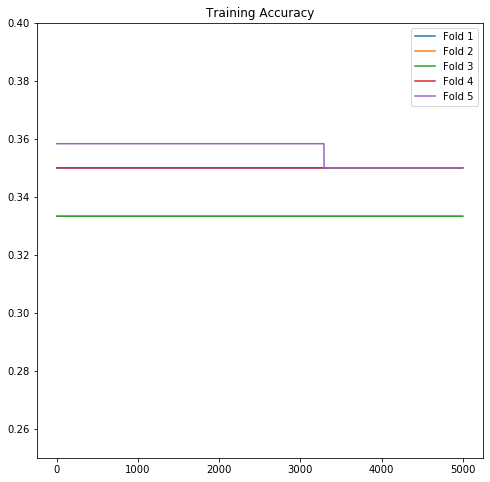

In [11]:
AccuracyPlot(accuracy)